# 1.資料下載及預處理
- 使用自定義類別 `DataCollector` 從資料庫下載我們要的資料。
- 套件`tqdm`可以展示出進度條，方便我們了解資料處理的進度。

In [1]:
from DataCollector import DataCollector
from tqdm import tqdm
from os import makedirs

makedirs('data', exist_ok=True)

- 暫時關閉`warning`以避免警告訊息影響進度條展示。
- 迭代101~111年四個季度的資料。
- 寫程式的當下時間，尚未釋出111-4資料，故從下載目錄移除。

In [2]:
versions = [(year, season) for year in range(101, 112) for season in range(1,5)]
versions.remove((111,4))

In [3]:
import warnings
warnings.filterwarnings('ignore')

for year, season in tqdm(versions):
        
        collector = DataCollector(year, season)
        collector.download()
        collector.extract()
        collector.fetch()
        collector.save()
        collector.remove()

100%|██████████| 43/43 [03:47<00:00,  5.29s/it]


# 2.處理及修正資料
- 將每個季度的資料結合成一份`DataFrame`

In [7]:
from os import listdir
from os.path import join
import pickle
import pandas as pd

df = pd.DataFrame()
data_dir = './data'

for filename in listdir(data_dir):
    
    path = join(data_dir, filename)

    with open(path, 'rb') as f:
        data = pickle.load(f)
        
    index = filename.split('.')[0]
        
    df_season = pd.DataFrame({index: data})
    df_season = df_season.T
    df = pd.concat([df, df_season], axis=0)
        
df = df.sort_index()

- 有些地區在該季度並無不動產交易紀錄時，`df`中會呈現為`NaN`。
- `fillna` 使用 `method='ffill'` 時，會使用最近一次的紀錄。
- `fillna(0)` 會將剩下來的空格補`0`。

In [8]:
df = df.fillna(method='ffill', axis=0)
df = df.fillna(0)
df.head()

,南投縣 中寮鄉,南投縣 仁愛鄉,南投縣 信義鄉,南投縣 南投市,南投縣 名間鄉,南投縣 國姓鄉,南投縣 埔里鎮,南投縣 水里鄉,南投縣 竹山鎮,南投縣 草屯鎮,...,高雄市 那瑪夏區,高雄市 阿蓮區,高雄市 鳥松區,高雄市 鳳山區,高雄市 鹽埕區,高雄市 鼓山區,新北市 烏來區,台東縣 金峰鄉,屏東縣 瑪家鄉,連江縣 東引鄉
101-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101-3,0.0,0.0,0.0,0.0,0.0,0.0,54911.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101-4,336.0,212.0,246.0,22248.0,2047.0,999.0,15174.0,18084.0,142.0,13580.0,...,149.0,4279.0,27626.0,37839.0,28606.0,49970.0,0.0,0.0,0.0,0.0
102-1,286.0,233.0,210.0,21780.0,1711.0,881.0,9680.0,1630.0,70.0,18691.0,...,179.0,6920.0,30400.0,39757.0,26953.0,50711.0,180.0,0.0,450.0,5103.0


# 3. 繪製動態長條圖
- 我們使用`bar_chart_race` 這個套件進行繪圖。
- 而`bar_chart_race` 背後運作的套件是 `matplotlib`。
- 由於`matplotlib` 本身並不支援中文字形，因此需要額外執行以下程式：
    1. 下載字型「台北黑體」。
    2. 將`.ttf`檔移動到`matplotlib`的字型目錄。
    3. 將台北黑體加入`matplotlib.pyplot`的參數。

In [ ]:
from wget import download
ttf_name = download('https://drive.google.com/u/0/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download')

import matplotlib
from os import rename
module_path = matplotlib.__file__[:-12]
font_path = join(module_path, 'mpl-data/fonts/ttf/', ttf_name)
rename(ttf_name, font_path)


import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

完成字型設定之後，我們就可以開始繪製圖像：

In [ ]:
makedirs('output', exist_ok=True)

from bar_chart_race import bar_chart_race
bar_chart_race(
    df=df,
    filename='result.gif',
    n_bars=25,
    dpi=100,
    fixed_max=True,
    period_length=1500,
    steps_per_period=20,
    title='全台各行政區房價中位數排名 Top 25\n(元/平方米)'
)

# 4. 分析資料
- 我們也可以把全部的資料輸出成csv:

In [9]:
df.to_csv('result.csv')

- 將資料與各區人口數量做比較
- 這裡採用110-4的資料

In [2]:
import pandas as pd
data = pd.read_csv('./population-and-price.csv')
data = data.iloc[:,1:].to_numpy()
population = data[:,0]
price = data[:,1]
density = data[:,2]

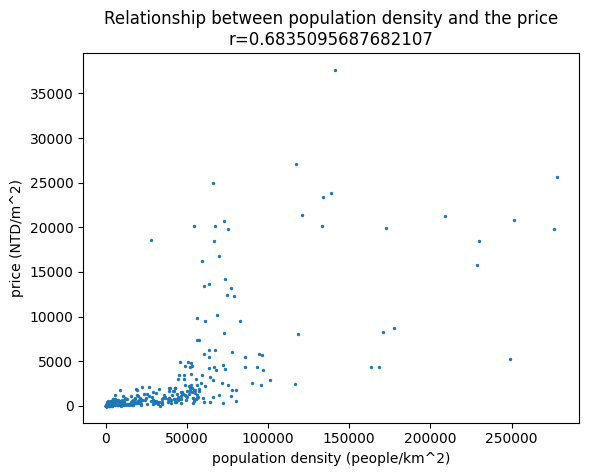

In [20]:
import numpy as np
import matplotlib.pyplot as plt

corrcoef = np.corrcoef(population, price)[0,1]

plt.title(f'Relationship between population density and the price\nr={corrcoef}')
plt.xlabel('population density (people/km^2)')
plt.ylabel('price (NTD/m^2)')
plt.scatter(price,density, s=2)

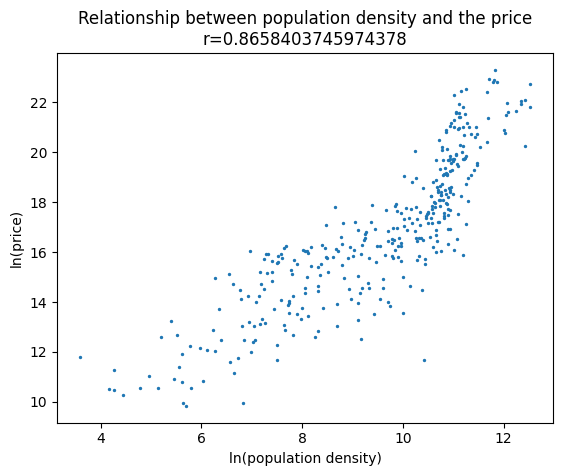

In [24]:
density_log = np.log(density*population)
price_log = np.log(price)

corrcoef = np.corrcoef(density_log, price_log)[0,1]

plt.title(f'Relationship between population density and the price\nr={corrcoef}')
plt.xlabel('ln(population density)')
plt.ylabel('ln(price)')
plt.scatter(price_log, density_log, s=2)